In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assume:
# x -> shape (14980, 14)
# y -> shape (14980,)

df = pd.read_csv("eeg_eye_state.csv")

#separate features and labels
x= df.iloc[:,:-1].values
y= df.iloc[:,-1].values

In [3]:
def create_sequences(x,y,window_size):
    x_seq = []
    y_seq = []
    
    for i in range(len(x) - window_size):
        x_seq.append(x[i:i+window_size])
        y_seq.append(y[i+window_size])
        
    return np.array(x_seq), np.array(y_seq)

window_size = 20
X_seq_raw, y_seq_raw = create_sequences(x, y, window_size)


In [4]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_seq_raw,
    y_seq_raw,
    test_size=0.2,
    stratify=y_seq_raw,
    random_state=42
)


In [5]:
scaler = StandardScaler()

# reshape to 2D
X_train_2D = X_train_raw.reshape(-1, X_train_raw.shape[-1])
X_test_2D  = X_test_raw.reshape(-1, X_test_raw.shape[-1])

# fit only on train
X_train_scaled = scaler.fit_transform(X_train_2D)
X_test_scaled  = scaler.transform(X_test_2D)

# reshape back to 3D
X_train = X_train_scaled.reshape(X_train_raw.shape)
X_test  = X_test_scaled.reshape(X_test_raw.shape)


# Single LSTM Model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

single_lstm_model = Sequential()

single_lstm_model.add(
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]))
)

single_lstm_model.add(Dropout(0.3))
single_lstm_model.add(Dense(1, activation='sigmoid'))

single_lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_single = single_lstm_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)



C:\Users\vinit\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5930 - loss: 0.6462 - val_accuracy: 0.7363 - val_loss: 0.5024
Epoch 2/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7407 - loss: 0.4970 - val_accuracy: 0.8272 - val_loss: 0.3766
Epoch 3/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8392 - loss: 0.3626 - val_accuracy: 0.8666 - val_loss: 0.3060
Epoch 4/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8810 - loss: 0.2829 - val_accuracy: 0.9044 - val_loss: 0.2319
Epoch 5/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9128 - loss: 0.2212 - val_accuracy: 0.9335 - val_loss: 0.1740
Epoch 6/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9294 - loss: 0.1785 - val_accuracy: 0.9298 - val_loss: 0.1754
Epoch 7/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9427 - loss: 0.1488 - val_accuracy: 0.9579 - val_loss: 0.1142
Epoch 8/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9519 - loss: 0.1196 - val_accu

In [7]:

loss_single, acc_single = single_lstm_model.evaluate(X_test, y_test)
print("Single LSTM Test Accuracy:", acc_single)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9941 - loss: 0.0160
Single LSTM Test Accuracy: 0.9943181872367859


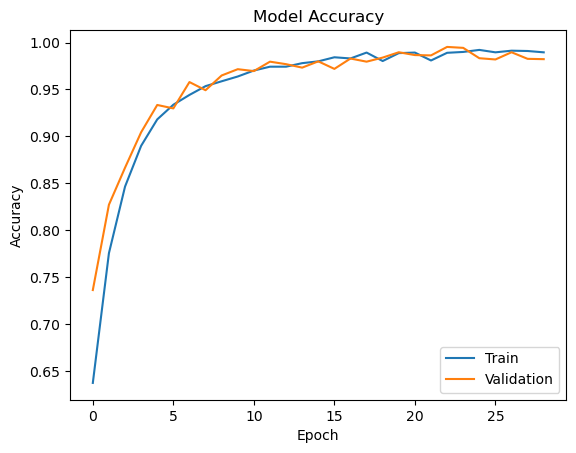

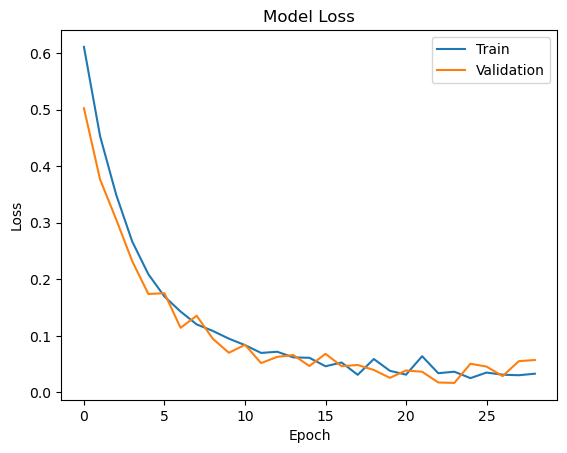

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_single.history['accuracy'])
plt.plot(history_single.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

plt.figure()
plt.plot(history_single.history['loss'])
plt.plot(history_single.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.show()


# Stacked LSTM Model

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

stacked_lstm_model = Sequential()

stacked_lstm_model.add(
    LSTM(64, return_sequences=True,
         input_shape=(X_train.shape[1], X_train.shape[2]))
)

stacked_lstm_model.add(LSTM(32))
stacked_lstm_model.add(Dropout(0.3))
stacked_lstm_model.add(Dense(1, activation='sigmoid'))

stacked_lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_stacked = stacked_lstm_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)



Epoch 1/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6166 - loss: 0.6331 - val_accuracy: 0.7386 - val_loss: 0.5023
Epoch 2/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7515 - loss: 0.4859 - val_accuracy: 0.8275 - val_loss: 0.3809
Epoch 3/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8513 - loss: 0.3420 - val_accuracy: 0.8987 - val_loss: 0.2513
Epoch 4/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9046 - loss: 0.2415 - val_accuracy: 0.9081 - val_loss: 0.2420
Epoch 5/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9241 - loss: 0.1986 - val_accuracy: 0.9362 - val_loss: 0.1653
Epoch 6/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9462 - loss: 0.1504 - val_accuracy: 0.9515 - val_loss: 0.1312
Epoch 7/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9535 - loss: 0.1224 - val_accuracy: 0.9642 - val_loss: 0.1040
Epoch 8/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9627 - loss: 0.1040 - val_acc

In [9]:
loss_stacked, acc_stacked = stacked_lstm_model.evaluate(X_test, y_test)
print("Stacked LSTM Test Accuracy:", acc_stacked)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9986 - loss: 0.0080
Stacked LSTM Test Accuracy: 0.9979946613311768


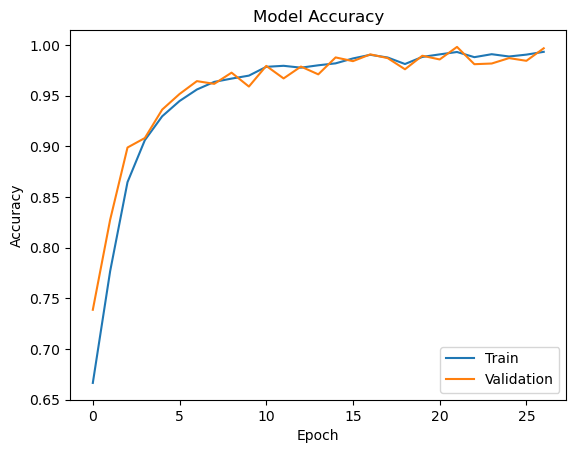

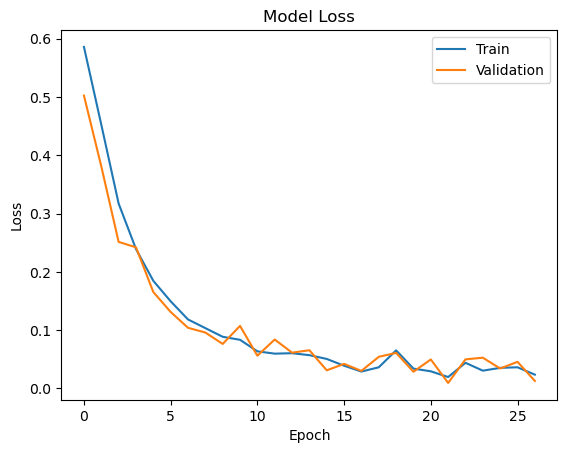

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_stacked.history['accuracy'])
plt.plot(history_stacked.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

plt.figure()
plt.plot(history_stacked.history['loss'])
plt.plot(history_stacked.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.show()


# CNN LSTM Model

In [10]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

cnn_lstm_model = Sequential()

cnn_lstm_model.add(
    Conv1D(filters=32,
           kernel_size=3,
           activation='relu',
           input_shape=(X_train.shape[1], X_train.shape[2]))
)

cnn_lstm_model.add(MaxPooling1D(pool_size=2))

cnn_lstm_model.add(LSTM(50))

cnn_lstm_model.add(Dropout(0.3))
cnn_lstm_model.add(Dense(1, activation='sigmoid'))

cnn_lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_cnn = cnn_lstm_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)



C:\Users\vinit\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6040 - loss: 0.6379 - val_accuracy: 0.7510 - val_loss: 0.5018
Epoch 2/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7577 - loss: 0.4774 - val_accuracy: 0.8058 - val_loss: 0.4118
Epoch 3/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8250 - loss: 0.3855 - val_accuracy: 0.8463 - val_loss: 0.3498
Epoch 4/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8762 - loss: 0.2957 - val_accuracy: 0.9064 - val_loss: 0.2425
Epoch 5/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9055 - loss: 0.2407 - val_accuracy: 0.9088 - val_loss: 0.2353
Epoch 6/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9296 - loss: 0.1847 - val_accuracy: 0.8947 - val_loss: 0.2515
Epoch 7/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9344 - loss: 0.1727 - val_accuracy: 0.9395 - val_loss: 0.1527
Epoch 8/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9472 - loss: 0.1329 - val_accuracy: 0.

In [11]:

loss_cnn, acc_cnn = cnn_lstm_model.evaluate(X_test, y_test)
print("CNN-LSTM Test Accuracy:", acc_cnn)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9939 - loss: 0.0169
CNN-LSTM Test Accuracy: 0.9926470518112183


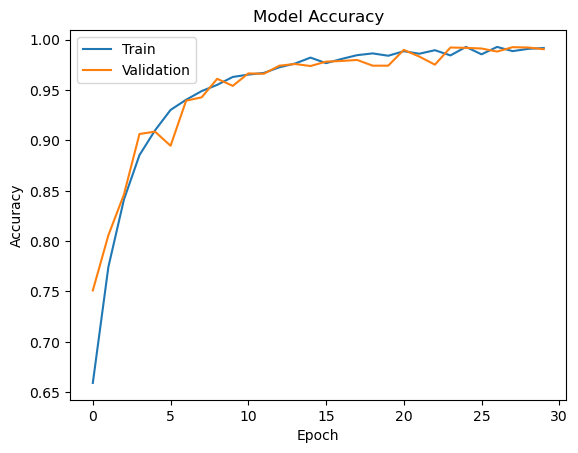

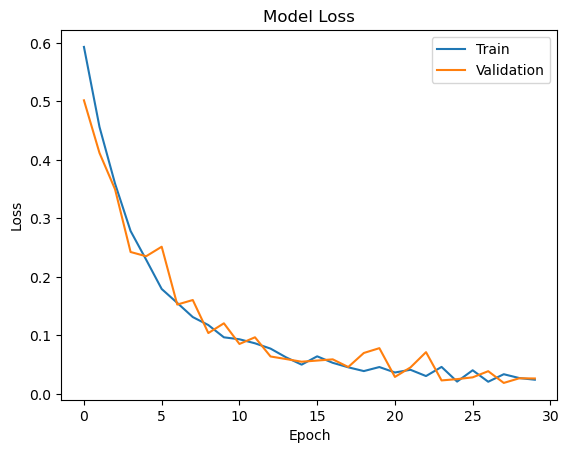

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

plt.figure()
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.show()


In [20]:
print("Train distribution:", np.bincount(y_train))
print("Test distribution:", np.bincount(y_test))


Train distribution: [6590 5378]
Test distribution: [1647 1345]


In [13]:
results = {
    "Single LSTM": acc_single,
    "Stacked LSTM": acc_stacked,
    "CNN-LSTM": acc_cnn
}

for model, acc in results.items():
    print(f"{model}: {acc:.4f}")


Single LSTM: 0.9943
Stacked LSTM: 0.9980
CNN-LSTM: 0.9926


In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = (stacked_lstm_model.predict(X_test) > 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
[[1644    3]
 [   3 1342]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1647
           1       1.00      1.00      1.00      1345

    accuracy                           1.00      2992
   macro avg       1.00      1.00      1.00      2992
weighted avg       1.00      1.00      1.00      2992



In [19]:
stacked_lstm_model.save("best_stacked_lstm_model.h5")

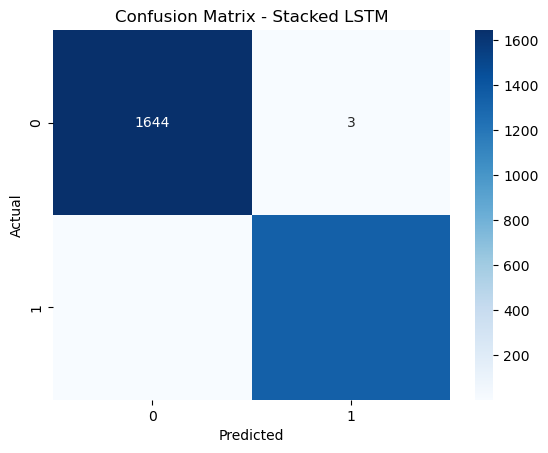

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Stacked LSTM")
plt.show()


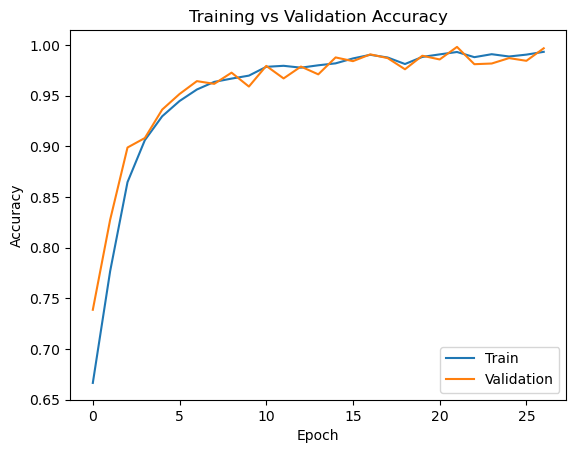

In [22]:
plt.figure()
plt.plot(history_stacked.history['accuracy'])
plt.plot(history_stacked.history['val_accuracy'])
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.show()
